In [1]:
# -*- coding: utf-8 -*-
"""
Transfer Learning tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting this notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios looks as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.

"""
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
import os
import pdb

plt.ion()   # interactive mode

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
# The problem we're going to solve today is to train a model to classify
# **ants** and **bees**. We have about 120 training images each for ants and bees.
# There are 75 validation images for each class. Usually, this is a very
# small dataset to generalize upon, if trained from scratch. Since we
# are using transfer learning, we should be able to generalize reasonably
# well.
#
# This dataset is a very small subset of imagenet.
# 
# .. Note ::
#    Download the data from
#    `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
#    and extract it to the current directory.

# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../../data/lab1/imgFolders/CUB_10_Subset'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()


In [2]:
dsets['train'].classes

['003.Sooty_Albatross',
 '031.Black_billed_Cuckoo',
 '032.Mangrove_Cuckoo',
 '046.Gadwall',
 '069.Rufous_Hummingbird',
 '080.Green_Kingfisher',
 '125.Lincoln_Sparrow',
 '128.Seaside_Sparrow',
 '129.Song_Sparrow',
 '139.Scarlet_Tanager']

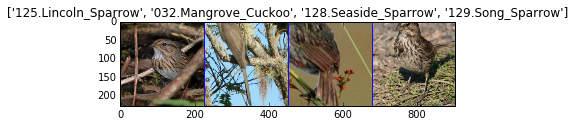

In [3]:
######################################################################
# Visualize a few images
# ^^^^^^^^^^^^^^^^^^^^^^
# Let's visualize a few training images so as to understand the data
# augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])




In [4]:
######################################################################
# Training the model
# ------------------
#
# Now, let's write a general function to train a model. Here, we will
# illustrate:
#
# -  Scheduling the learning rate
# -  Saving (deep copying) the best model
#
# In the following, parameter ``lr_scheduler(optimizer, epoch)``
# is a function  which modifies ``optimizer`` so that the learning
# rate is changed according to desired schedule.

def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

######################################################################
# Learning rate scheduler
# ^^^^^^^^^^^^^^^^^^^^^^^
# Let's create our learning rate scheduler. We will exponentially
# decrease the learning rate once every few epochs.

def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer


######################################################################
# Visualizing the model predictions
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# Generic function to display predictions for a few images
#

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return


In [31]:
#modelClass = models.resnet18(pretrained=False)
#model_ft = modelClass.load_state_dict(torch.nn.state_dict('../../data/pretrained/resnet18-5c106cde.pth'))
#model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
#model_ft = model.load_state_dict(model_zoo.load_url('../../data/pretrained/resnet18-5c106cde.pth'))

#model_ft = models.resnet18(pretrained=False)
#model_ft.load_state_dict(torch.load('../../data/pretrained/resnet18-5c106cde.pth'))

model_ft = models.alexnet(pretrained=False)
model_ft.load_state_dict(torch.load('../../data/pretrained/alexnet-owt-4df8aa71.pth'))
#model_ft.load_state_dict(torch.load('../../data/pretrained/resnet18-5c106cde.pth'))

#for idx, m in enumerate(model_ft.modules()):
#    print(idx, '->', m)
# modelClass.conv1.state_dict()['weight']


In [37]:
model_ft = models.alexnet(pretrained=False)
model_ft.load_state_dict(torch.load('../../data/lab1/pretrained/alexnet-owt-4df8aa71.pth'))

mod = list(model_ft.classifier.children())
mod.pop()


mod.append(torch.nn.Linear(4096, 10))
new_classifier = nn.Sequential(*mod)

model_ft.classifier = new_classifier
print(model_ft)

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 10)
  )
)


Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.4031 Acc: 0.4849
val Loss: 0.2544 Acc: 0.6770

Epoch 1/24
----------
train Loss: 0.3221 Acc: 0.5753
val Loss: 0.3204 Acc: 0.6495

Epoch 2/24
----------
train Loss: 0.2709 Acc: 0.6656
val Loss: 0.2240 Acc: 0.7113

Epoch 3/24
----------
train Loss: 0.2503 Acc: 0.6722
val Loss: 0.3116 Acc: 0.7113

Epoch 4/24
----------
train Loss: 0.2381 Acc: 0.6789
val Loss: 0.2240 Acc: 0.6942

Epoch 5/24
----------
train Loss: 0.2627 Acc: 0.6421
val Loss: 0.1890 Acc: 0.7491

Epoch 6/24
----------
train Loss: 0.1830 Acc: 0.7692
val Loss: 0.2801 Acc: 0.6220

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.1764 Acc: 0.7659
val Loss: 0.1650 Acc: 0.7766

Epoch 8/24
----------
train Loss: 0.1158 Acc: 0.8696
val Loss: 0.1499 Acc: 0.7938

Epoch 9/24
----------
train Loss: 0.1022 Acc: 0.8662
val Loss: 0.1444 Acc: 0.8076

Epoch 10/24
----------
train Loss: 0.0985 Acc: 0.8696
val Loss: 0.1446 Acc: 0.8144

Epoch 11/24
----------
train Loss: 0.0714 Acc: 

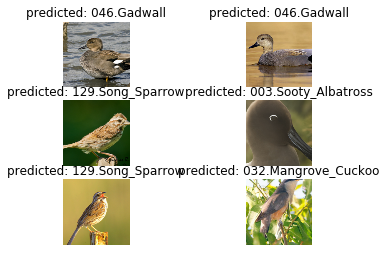

In [38]:
######################################################################
# Finetuning the convnet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
#

#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# It should take around 15-25 min on CPU. On GPU though, it takes less than a
# minute.
#

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

######################################################################
#

visualize_model(model_ft)




Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.3346 Acc: 0.5886
val Loss: 0.2136 Acc: 0.7629

Epoch 1/24
----------
train Loss: 0.1777 Acc: 0.8060
val Loss: 0.1964 Acc: 0.7869

Epoch 2/24
----------
train Loss: 0.1230 Acc: 0.8528
val Loss: 0.1762 Acc: 0.7938

Epoch 3/24
----------
train Loss: 0.1350 Acc: 0.8328
val Loss: 0.1940 Acc: 0.7663

Epoch 4/24
----------
train Loss: 0.0911 Acc: 0.8629
val Loss: 0.1839 Acc: 0.7904

Epoch 5/24
----------
train Loss: 0.1193 Acc: 0.8696
val Loss: 0.1972 Acc: 0.7869

Epoch 6/24
----------
train Loss: 0.0684 Acc: 0.9264
val Loss: 0.2165 Acc: 0.7801

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0909 Acc: 0.8930
val Loss: 0.1659 Acc: 0.8110

Epoch 8/24
----------
train Loss: 0.0592 Acc: 0.9398
val Loss: 0.1537 Acc: 0.8247

Epoch 9/24
----------
train Loss: 0.0582 Acc: 0.9231
val Loss: 0.1515 Acc: 0.8351

Epoch 10/24
----------
train Loss: 0.0642 Acc: 0.9231
val Loss: 0.1511 Acc: 0.8454

Epoch 11/24
----------
train Loss: 0.0482 Acc: 

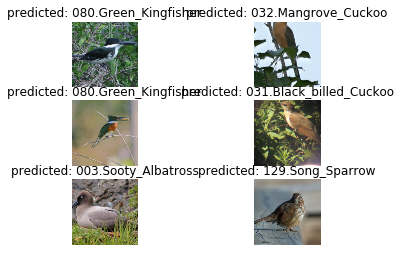

In [46]:
######################################################################
# ConvNet as fixed feature extractor
# ----------------------------------
#
# Here, we need to freeze all the network except the final layer. We need
# to set ``requires_grad == False`` to freeze the parameters so that the
# gradients are not computed in ``backward()``.
#
# You can read more about this in the documentation
# `here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.
#

model_conv = torchvision.models.alexnet(pretrained=False)
model_conv.load_state_dict(torch.load('../../data/lab1/pretrained/alexnet-owt-4df8aa71.pth'))

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
mod = list(model_ft.classifier.children())
mod.pop()

mod.append(torch.nn.Linear(4096, 10))
new_classifier = nn.Sequential(*mod)

model_conv.classifier = new_classifier

#num_ftrs = model_conv.fc.in_features
#model_conv.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.01, momentum=0.9)


######################################################################
# Train and evaluate
# ^^^^^^^^^^^^^^^^^^
#
# On CPU this will take about half the time compared to previous scenario.
# This is expected as gradients don't need to be computed for most of the
# network. However, forward does need to be computed.
#

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

######################################################################
#

visualize_model(model_conv)

plt.ioff()
plt.show()